In [67]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans


from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

import xgboost as xgb

import imblearn
from collections import Counter

---
## Data Preprocessing and EDA

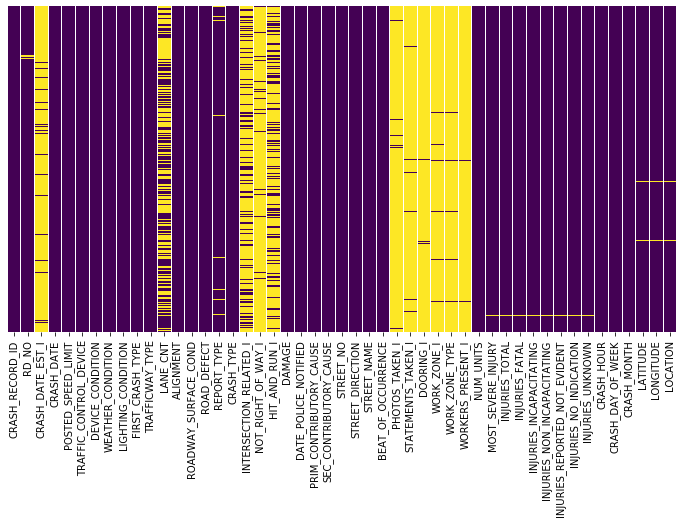

In [8]:
accidents = pd.read_csv('data/traffic_crashes.csv')
plt.figure(figsize=(12,6))
sns.heatmap(accidents.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [9]:
# Develop classification flag.
# Positive represents the accideent resulted in incapacitation and/or fatality.
accidents['crash_date'] = pd.to_datetime(accidents['CRASH_DATE'])
accidents['crash_year'] = accidents['crash_date'].dt.year
accidents['fatal_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'FATAL', 1, 0)
accidents['incap_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'INCAPACITATING INJURY', 1, 0)
accidents['fatal_incap'] = accidents['fatal_bool'] + accidents['incap_bool']
accidents.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,crash_date,crash_year,fatal_bool,incap_bool,fatal_incap
0,00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e79...,JC201794,NaN,03/27/2019 04:20:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,...,4,3,41.994704,-87.699395,POINT (-87.699395085278 41.994703544264),2019-03-27 16:20:00,2019,0,0,0
1,0002fb938eb0feaea33820fa55b71e4ea0b332125e1510...,JB175900,NaN,03/06/2018 03:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,...,3,3,41.904671,-87.716685,POINT (-87.716685434641 41.904671135876),2018-03-06 15:00:00,2018,0,0,0
2,0003fc68d857da032b1beafa8f7893ce0b123ce6b2dee5...,HZ488533,NaN,10/25/2016 02:10:00 PM,30,TRAFFIC SIGNAL,UNKNOWN,CLEAR,DAYLIGHT,REAR END,...,3,10,41.706808,-87.642771,POINT (-87.642771373276 41.706807861572),2016-10-25 14:10:00,2016,0,0,0
3,00060f93d2ae8d4e4c7fe75ac17055dd69a081d0b928a5...,JD123586,NaN,01/21/2020 04:16:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,...,3,1,41.791610,-87.703356,POINT (-87.703355598231 41.791609871969),2020-01-21 16:16:00,2020,0,0,0
4,0006882952e53c291df267014a03b57684383e9ad66d9e...,JC459747,NaN,10/04/2019 12:00:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,6,10,41.848490,-87.675599,POINT (-87.67559940405 41.848490427751),2019-10-04 12:00:00,2019,0,0,0


In [10]:
# Started collecting data for the entire city in September 2017.
# Data collection became more formalized.
# Omitting data prior to March 2020 due to Covid-19 pandemic.
accidents = accidents[(accidents['crash_date'] > '2017-08-31') & (accidents['crash_date'] < '2020-03-01')]
len(accidents)

292080

In [70]:
num_pos_obs = sum(accidents['fatal_incap'])
num_neg_obs = len(accidents['fatal_incap']) - num_pos_obs
print("# of POSITIVE Obs.: ", num_pos_obs)
print("# of NEGATIVE Obs.: ", num_neg_obs)
print("% of Positive Obs. (Fatalities): ", round(sum(accidents['fatal_incap']) / len(accidents['fatal_incap']), 4))

# of POSITIVE Obs.:  5358
# of NEGATIVE Obs.:  286722
% of Positive Obs. (Fatalities):  0.0183


Returns True if Total Accidents Reconcile:  True


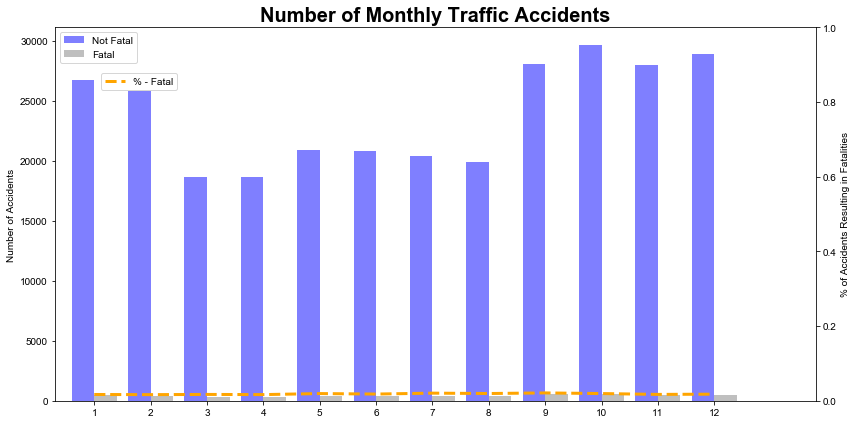

In [38]:
# Create data frame
month_grpd = accidents.groupby(['CRASH_MONTH', 'fatal_incap']).agg({'fatal_incap':'count'})
month_grpd.columns = ['count']
month_grpd.reset_index(inplace=True)
month_no_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 0]
month_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 1]

month_fatal_df = pd.DataFrame()
month_fatal_df['month'] = pd.Series(range(1,13))
month_fatal_df['num_not_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 0]['count'])
month_fatal_df['num_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 1]['count'])
month_fatal_df['total'] = month_fatal_df['num_not_fatal'] + month_fatal_df['num_fatal']
month_fatal_df['prcnt_fatal'] = month_fatal_df['num_fatal'] / month_fatal_df['total']

pos = list(range(len(month_fatal_df['month'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos, month_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos], month_fatal_df['num_fatal'], width, alpha=0.5, color='grey', label='Fatal')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks([p + 0.5 * width for p in pos])
ax1.set_xticklabels(month_fatal_df['month'])
ax1.set_title('Number of Monthly Traffic Accidents', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, 13)

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'arial'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities')
ax2.set_ylim(0,1)
ax2.plot([p + width/2 for p in pos], month_fatal_df['prcnt_fatal'] , color='orange', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.167, 0.89), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

# check math
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(month_fatal_df['total'])==len(accidents)))

Returns TRUE if Total # of Accidents Reconcile:  True


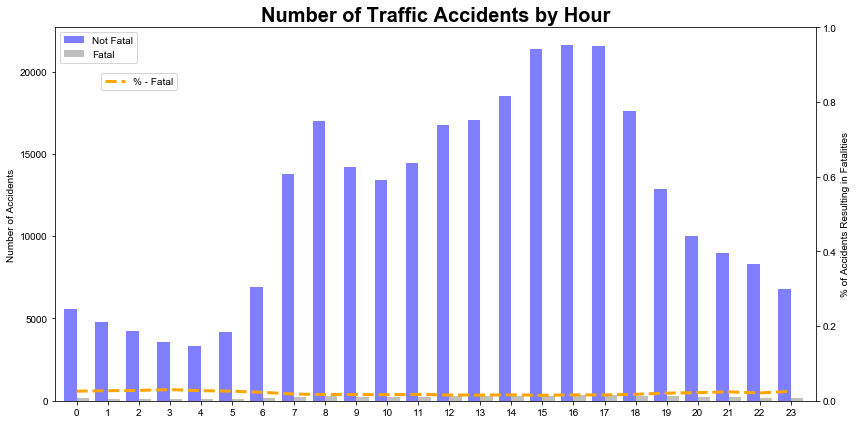

In [43]:
# Compare Hourly Data

hour_grpd = accidents.groupby(['CRASH_HOUR', 'fatal_incap']).agg({'fatal_incap':'count'})
hour_grpd.columns = ['count']
hour_grpd.reset_index(inplace=True)
hour_no_fatal = hour_grpd[hour_grpd['fatal_incap'] == 0]
hour_fatal_ = hour_grpd[hour_grpd['fatal_incap'] == 1]

hour_fatal_df = pd.DataFrame()
hour_fatal_df['hour'] = pd.Series(range(0,24))
hour_fatal_df['num_not_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 0]['count'])
hour_fatal_df['num_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 1]['count'])
hour_fatal_df['total'] = hour_fatal_df['num_not_fatal'] + hour_fatal_df['num_fatal']
hour_fatal_df['prcnt_fatal'] = hour_fatal_df['num_fatal'] / hour_fatal_df['total']

pos = list(range(len(hour_fatal_df['hour'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos, hour_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos], hour_fatal_df['num_fatal'], width, alpha=0.5, color='grey', label='Fatal')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks([p + 0.5 * width for p in pos])
ax1.set_xticklabels(hour_fatal_df['hour'])
ax1.set_title('Number of Traffic Accidents by Hour', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, len(hour_fatal_df))

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'arial'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities')
ax2.set_ylim(0,1)
ax2.plot([p + width/2 for p in pos], hour_fatal_df['prcnt_fatal'] , color='orange', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.167, 0.89), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

# check math
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(hour_fatal_df['total'])==len(accidents)))

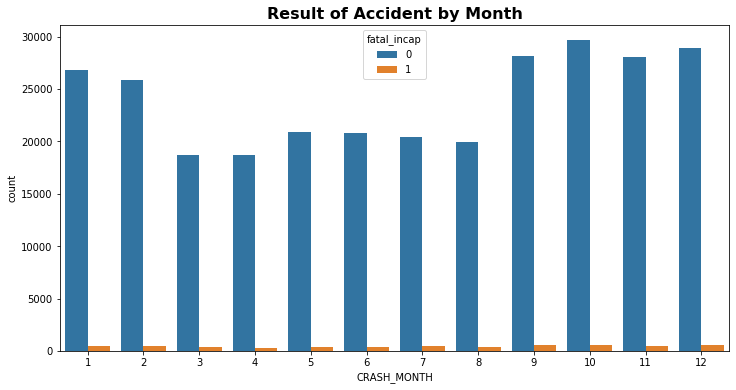

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='CRASH_MONTH', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Month", fontsize=16, fontweight='bold');

In [44]:
accidents.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

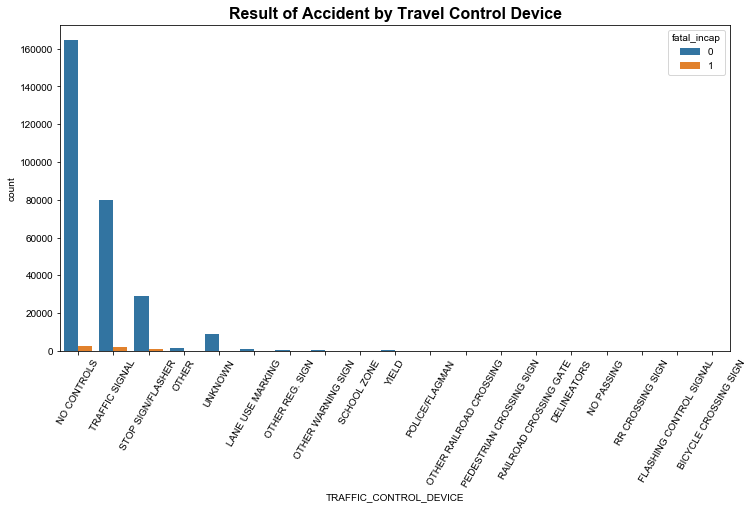

In [47]:
plt.figure(figsize=(12,6))
sns.countplot(x='TRAFFIC_CONTROL_DEVICE', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

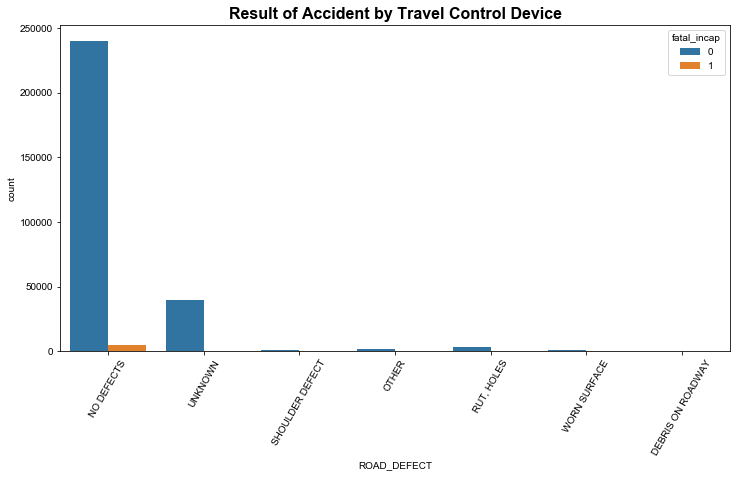

In [48]:
plt.figure(figsize=(12,6))
sns.countplot(x='ROAD_DEFECT', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

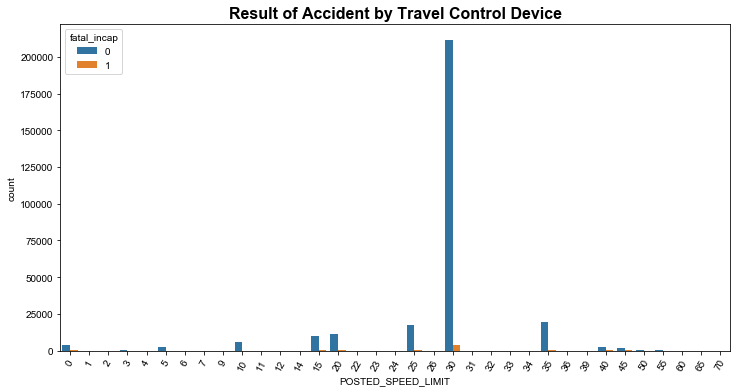

In [49]:
plt.figure(figsize=(12,6))
sns.countplot(x='POSTED_SPEED_LIMIT', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

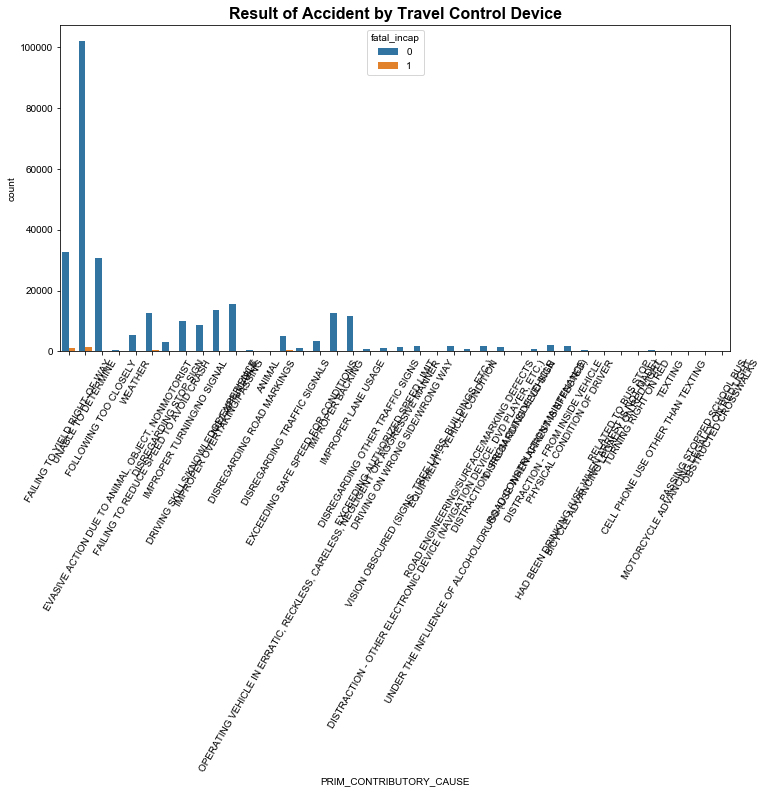

In [50]:
plt.figure(figsize=(12,6))
sns.countplot(x='PRIM_CONTRIBUTORY_CAUSE', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

In [57]:
accidents.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

---
## Managing Data Imbalance

In [59]:
accidents2 = accidents[['CRASH_RECORD_ID', 'RD_NO', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                        'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 
                        'ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 
                        'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 
                        'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 
                        'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE',
                        'WORKERS_PRESENT_I', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
                        'LATITUDE', 'LONGITUDE', 'LOCATION', 'crash_date', 'crash_year','fatal_incap']].copy()

In [62]:
X_imbl = accidents2.drop('fatal_incap', axis=1)
y_imbl = accidents2[['fatal_incap']]

In [ ]:
### XGBoost - 

### SMOTE